# Test plane extraction for a single point cloud

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import time
import open3d as o3d

import planeslam.general as general
from planeslam.mesh import LidarMesh
from planeslam.scan import Scan
from planeslam.clustering import cluster_mesh_graph_search, mesh_cluster_pts
from planeslam.extraction import scan_from_clusters
import planeslam.io as io

%load_ext autoreload
%autoreload 2
%load_ext line_profiler

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


Read Point Cloud from pcd file

In [2]:
binpath = os.path.join(os.getcwd(),'..', 'data', 'airsim', 'blocks_60_samples_loop_closure', 'lidar', 'Drone0')
PCs = io.read_lidar_bin(binpath)
P = PCs[15]

In [3]:
# Convert points to ENU
P = general.NED_to_ENU(P)

# Downsample the points
P = general.downsample(P, factor=2, axis=0)

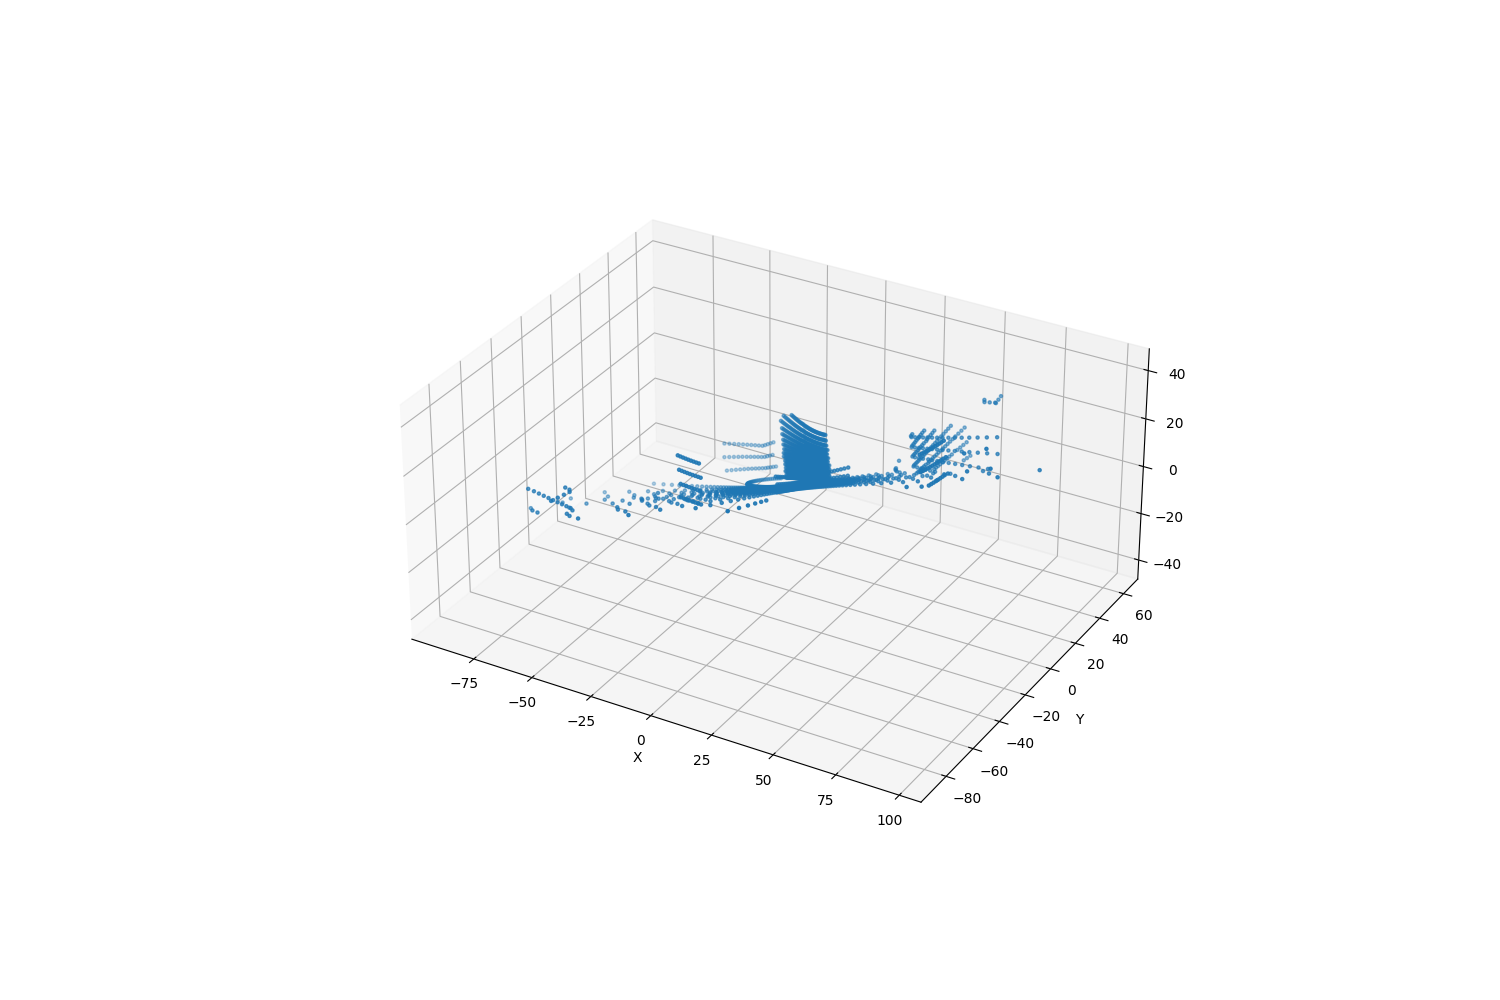

In [4]:
# Plot the points
ax = general.plot_3D_setup(P)
ax.scatter3D(P[:,0], P[:,1], P[:,2], marker='.')  

Cluster the points

In [5]:
# Create the mesh
start_time = time.time()
mesh = LidarMesh(P)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.03899574279785156


In [6]:
start_time = time.time()
mesh.prune(edge_len_lim=10)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.1139986515045166


In [7]:
# Cluster the mesh with graph search
start_time = time.time()
clusters, avg_normals = cluster_mesh_graph_search(mesh)
print("elapsed time: ", time.time() - start_time)

elapsed time:  0.054998159408569336


In [8]:
#%lprun -f cluster_mesh_graph_search cluster_mesh_graph_search(mesh)

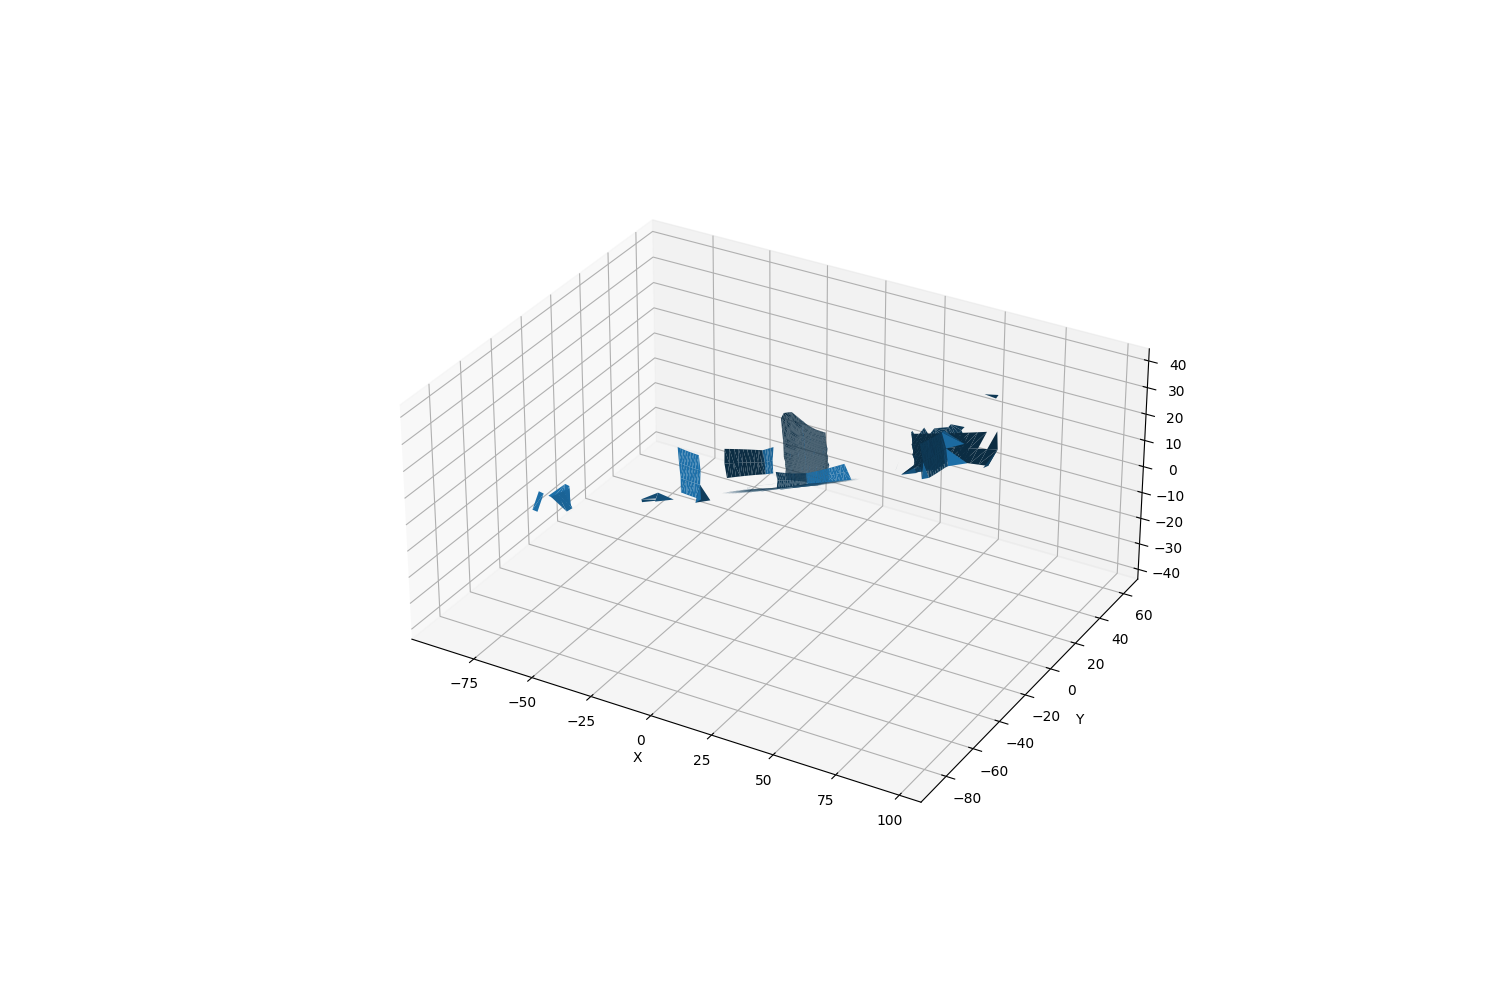

In [9]:
# Plot mesh
ax = general.plot_3D_setup(P)

ax.plot_trisurf(P[:,0], P[:,1], P[:,2], triangles=mesh.DT.simplices)

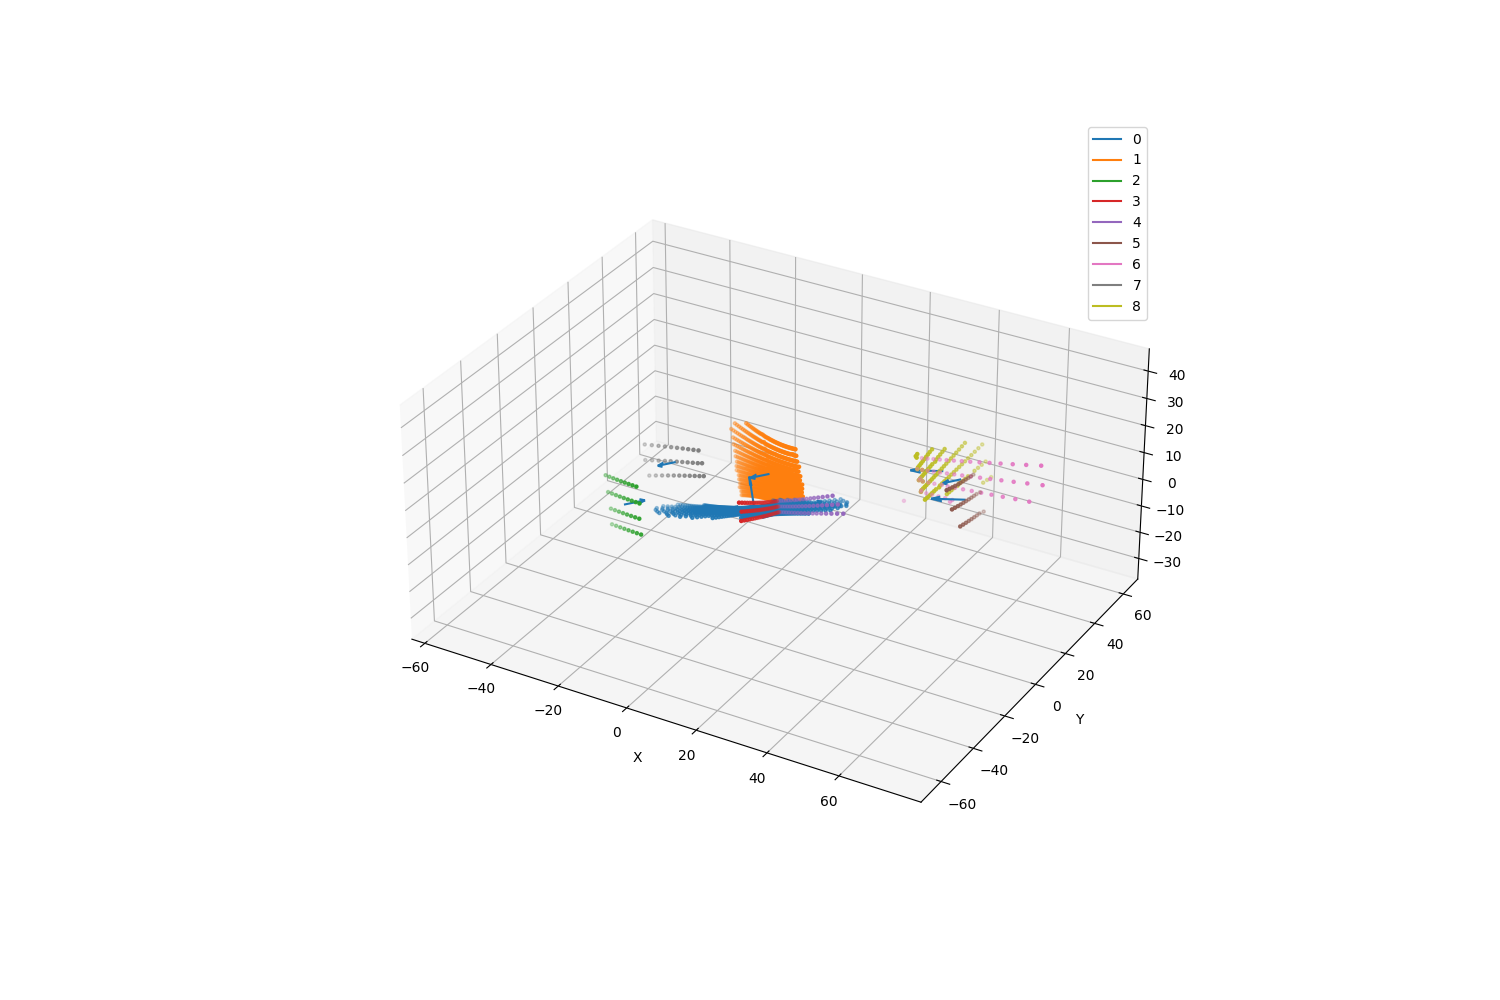

In [10]:
# Plot clusters
ax = general.plot_3D_setup(P)

cmap = cm.get_cmap('plasma')
cmap_idxs = int(len(cmap.colors) / len(clusters)) * np.arange(len(clusters))
colors = np.asarray(cmap.colors)[cmap_idxs,:]

for i, c in enumerate(clusters):
    cluster_pts = mesh_cluster_pts(mesh, c)
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color='C'+str(i), marker='.')  

    # Show normals
    c = np.mean(cluster_pts, axis=0)
    n = 10 * avg_normals[i]
    ax.quiver(c[0], c[1], c[2], n[0], n[1], n[2])

general.color_legend(ax, len(clusters))

Extract planes

In [11]:
planes, vertices, faces = scan_from_clusters(mesh, clusters, avg_normals)
scan = Scan(planes, vertices, faces)

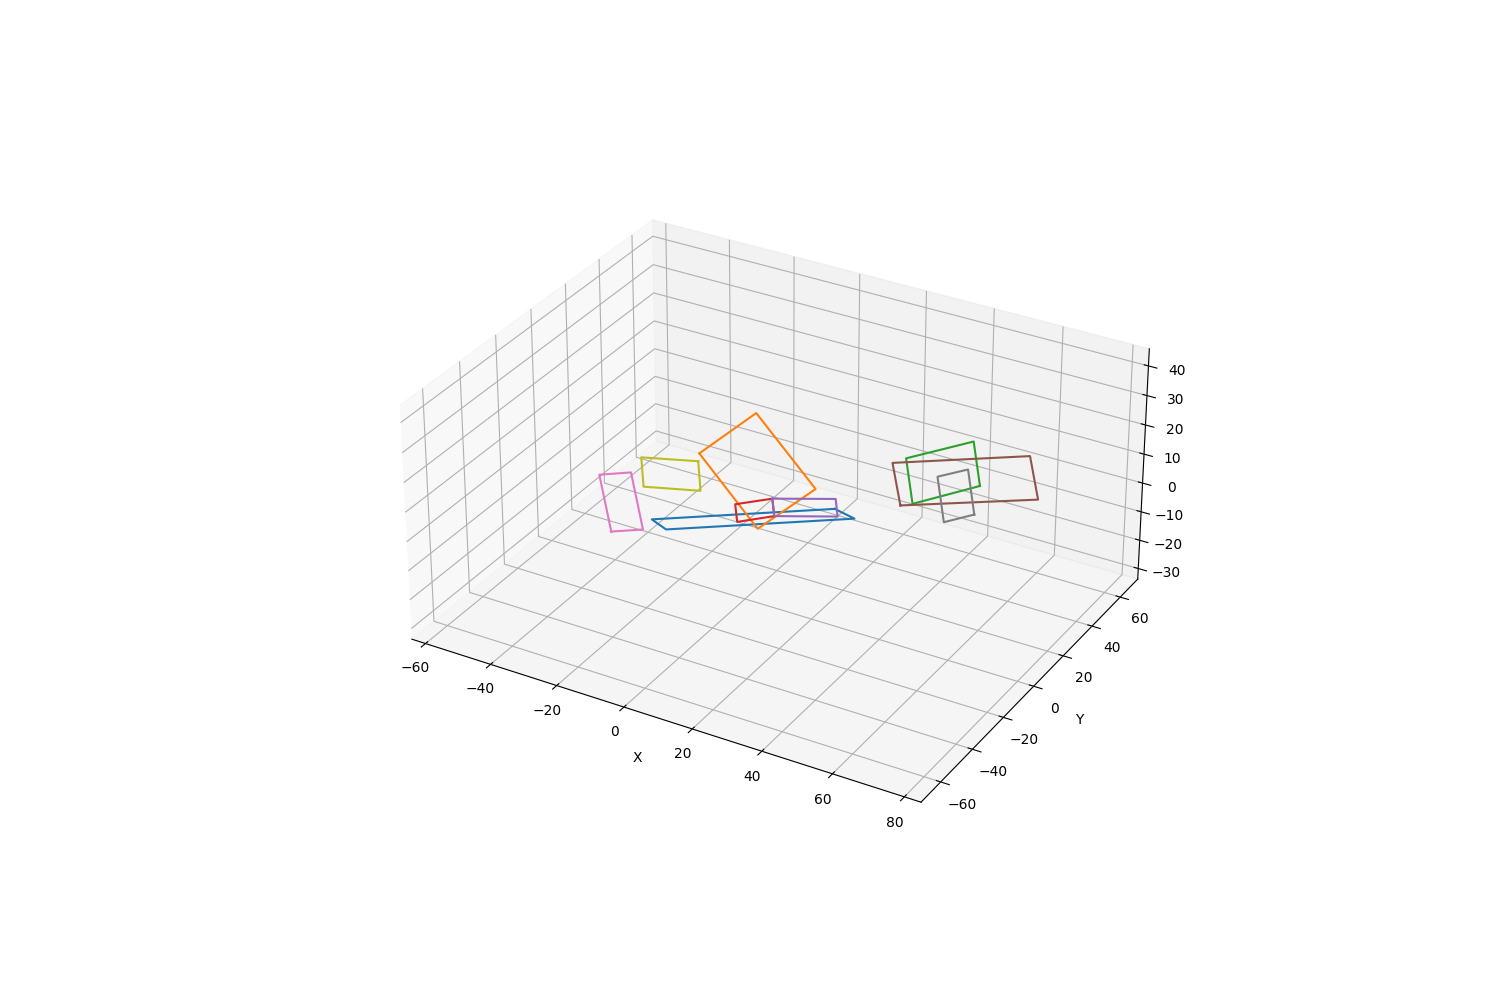

In [12]:
ax = general.plot_3D_setup(P)
scan.plot(ax, show_normals=False)

In [ ]:
i = 1
c = clusters[i]
n = avg_normals[i][:,None]
cluster_pts = mesh_cluster_pts(mesh, c)  # Extract points from cluster

In [ ]:
cluster_pts

In [ ]:
from planeslam.extraction import bd_plane_from_pts
plane_pts = bd_plane_from_pts(cluster_pts, n)

In [ ]:
plane_pts